# Introduction



---



---



In this notebook, we will implement the following tests for the NONLINEAR KOPTEVA PROBLEM:


a) For each epsilon:

i) Until mesh convergence

- Physical solve based on current mesh
- Compute Hessian M based on the current physical solution and mesh, take $\alpha_{hat} = \epsilon^{-3/4}$ (for $m=0$) or $\alpha_{hat} = \epsilon^{-5/4}$ (for $m=1$)
- Perform a mesh solve
- Continuation in $u$ and $x$

ii) Continuation in $u$ and $x$

b) Compare errors, solutions, etc


# Where Do These Scalings Come From?


---



---



I will work it out in the L2 case and leave the H1 case for the reader (lol).


## Step 1 - From my "Exploring_M_and_Epsilon_Relationship" notebook:





- This notebook shows us that the L1 norm of $|u''|$ behaves like $\frac{1}{\epsilon}.$ Thus, $|u''|$ behaves like $\frac{1}{\epsilon^2}.$

- To see this, note that the L1 norm of $|u''|$ is $$ \text{L1 Norm} = \text{width} \times |u''|  \approx \frac{1}{\epsilon}.$$
$$ (\text{width} = \epsilon)  \times |u''|  \approx \frac{1}{\epsilon}.$$
For this to be true, $$ | u'' | \approx \frac{1}{\epsilon^2}.$$


## Step 2 - The Scaling on $|u''|$ in $M$





In the L2 case, I formulate $M$ as $M = ( 1 + \frac{1}{\alpha} |u''| )^{4/5}.$ We want the integral of $M$ to be $O(1).$ Thus, we want
$$ \text{width} = \epsilon \times M \approx 1$$
or
$$ M \approx \epsilon^{-1}.$$

Based on Step 1, we have

$$ \left(\frac{1}{\alpha} |u''| \right)^{4/5} \approx \epsilon^{-1} $$
$$ \left(\frac{1}{\alpha} \epsilon^{-2} \right)^{4/5} \approx \epsilon^{-1} $$
$$ \left(\frac{1}{\alpha} \epsilon^{-2} \right) \approx \epsilon^{-5/4} $$
$$ \left(\frac{1}{\alpha}\right) \approx \epsilon^{-5/4} \epsilon^{2} = \epsilon^{3/4}.$$

Thus, we take

$$ \alpha = \text{constant} \times \epsilon^{-3/4}.$$

# Results and Comments


---



---


- Not all MP-Iterations converge, some mesh difference norms seem to 'stagnate.' Depsite this, the resulting meshes look pretty good. DAMPING PICARD ITERATION FIXED THIS!

- I do not yet have a desired mesh residual stopping criteria worked into the MP_Iteration. The current residual calculation does not seem very informative. SWITCHING TO NORM(MESHES) < MESH_TOL = (1/10)*EPSILON WAS BETTER!

- Could try to recover and continue other solutions.


In [1]:
# install firedrake

# hide output
%%capture

try:
    from firedrake import *
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    from firedrake import *

In [2]:
# Code in this cell makes plots appear an appropriate size and resolution in the browser window

%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (11, 6)

In [3]:
# import firedrake tools

from firedrake import *
import numpy as np
import matplotlib.pyplot as plt # firedrake makes use of matplotlib tools
from firedrake.pyplot import tripcolor, tricontour, triplot #firedrake plotting
from IPython.display import display
from mpl_toolkits import mplot3d



# Setup

In [4]:
# SETUP

# Mesh and space
N = 50
xi_mesh = UnitIntervalMesh(N)
V_mesh = FunctionSpace(xi_mesh, 'CG', 1)
V_phys = FunctionSpace(xi_mesh, "CG", 4)
V_residual = FunctionSpace(xi_mesh, "R", 0)
x = Function(V_mesh).interpolate(SpatialCoordinate(xi_mesh)[0])
perm_x =  np.argsort(x.dat.data[:])



# Solver paramaters


newton_params = {
        'snes_type': 'newtonls',
        # 'snes_monitor': None,
        # "snes_converged_reason": None,
        'ksp_type': 'preonly',
        'snes_linesearch_type': 'l2',
        # 'snes_linesearch_monitor': None,
        'snes_linesearch_damping': 0.5,
        'pc_type' : 'lu',
        'snes_rtol': 1e-8,
        'snes_stol': 1e-8,
        'snes_max_it': 100,
}


lu_params = {
    'snes_type': 'ksponly',
    # 'snes_monitor': None,
    'mat_type': 'aij',
    'ksp_type': 'preonly',
    'pc_type': 'lu',
}

# Numerical Test



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.1
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.5773502691896256
norm(u) =  1.0408329997330663



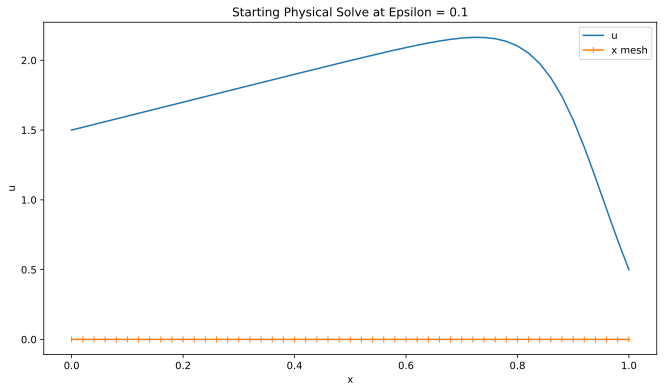




SINCE MESH TOLERANCE =  0.009604489391536217 WE HAVE MESH CONVERGENCE IN 6 MP ITERATIONS


____________________________________________________________________________________________________
RESULTS
____________________________________________________________________________________________________

MESH RESIDUALS:
33.87496636742647, 27.141050843579347, 24.945787090400437, 24.384670802117817, 24.33706385890623, 24.44801953186422, 

PLOT:


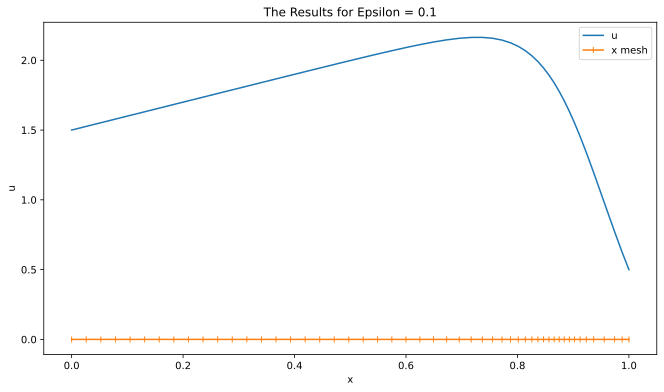

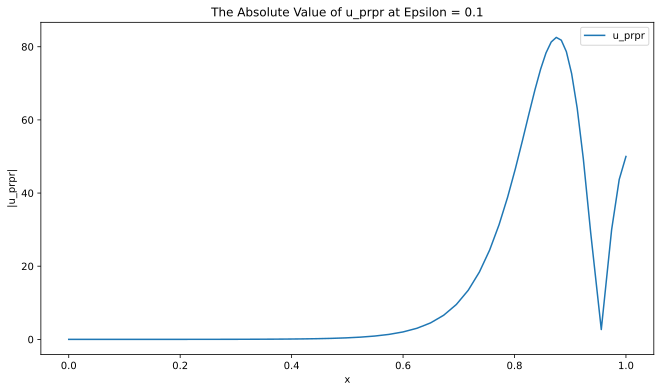



Epsilon continuation checks
norm(x) =  0.6557110560843318
norm(u) =  1.815906726400525



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.07500000000000001
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.6557110560843318
norm(u) =  1.815906726400525



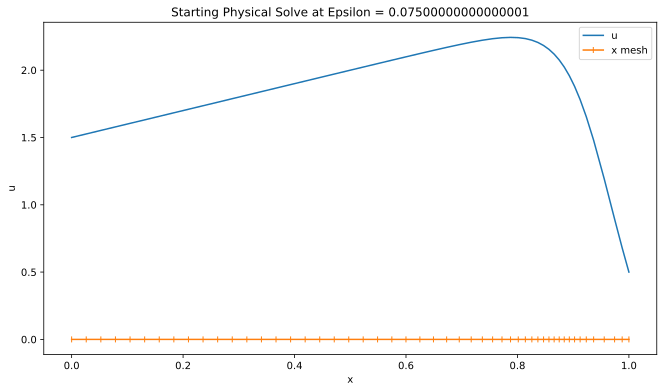




SINCE MESH TOLERANCE =  0.006333043233993549 WE HAVE MESH CONVERGENCE IN 4 MP ITERATIONS


____________________________________________________________________________________________________
RESULTS
____________________________________________________________________________________________________

MESH RESIDUALS:
30.06577135085969, 26.252909517758514, 25.291689633859882, 25.07233175932952, 

PLOT:


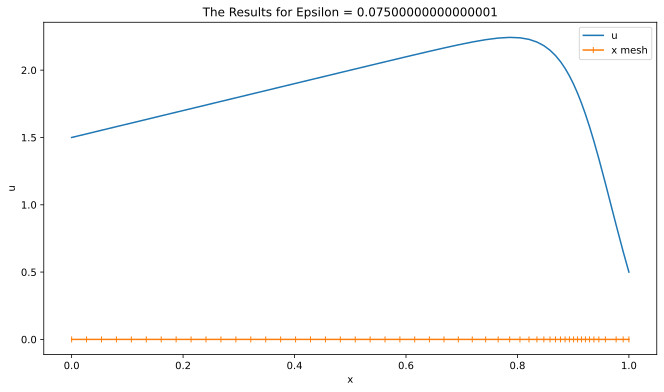

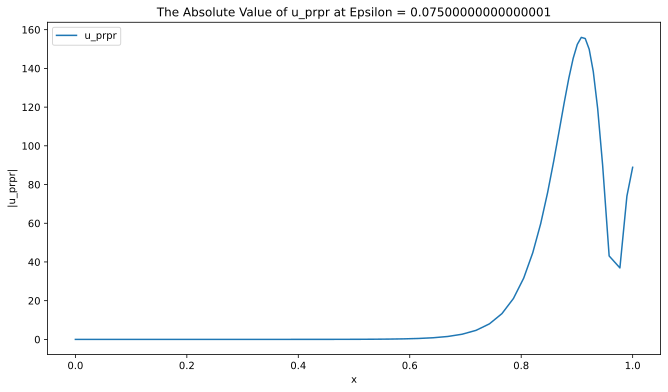



Epsilon continuation checks
norm(x) =  0.6723154511514431
norm(u) =  1.8698319912478127



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.05625000000000001
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.6723154511514431
norm(u) =  1.8698319912478127



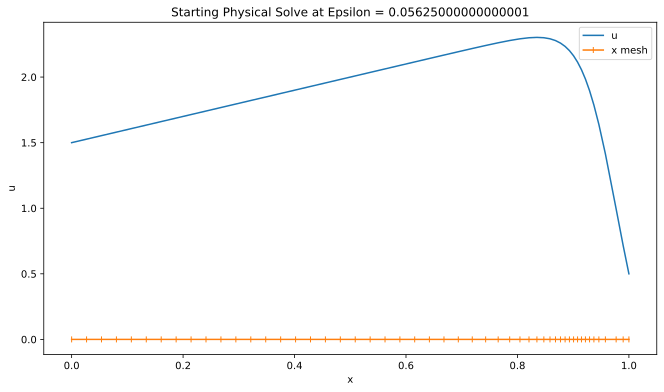




SINCE MESH TOLERANCE =  0.0052169213817827315 WE HAVE MESH CONVERGENCE IN 5 MP ITERATIONS


____________________________________________________________________________________________________
RESULTS
____________________________________________________________________________________________________

MESH RESIDUALS:
32.18411918644725, 26.885086923520387, 25.725308975873475, 25.40118662818699, 25.360288836304754, 

PLOT:


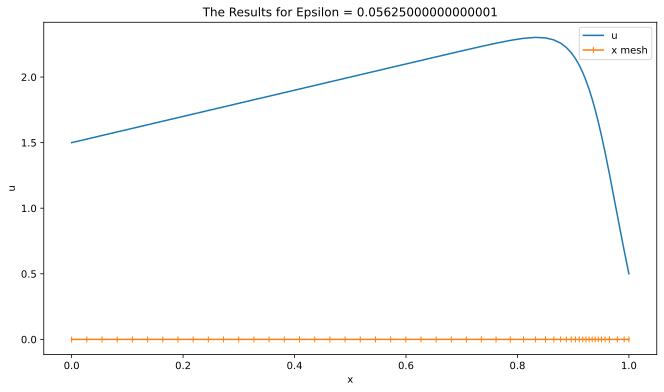

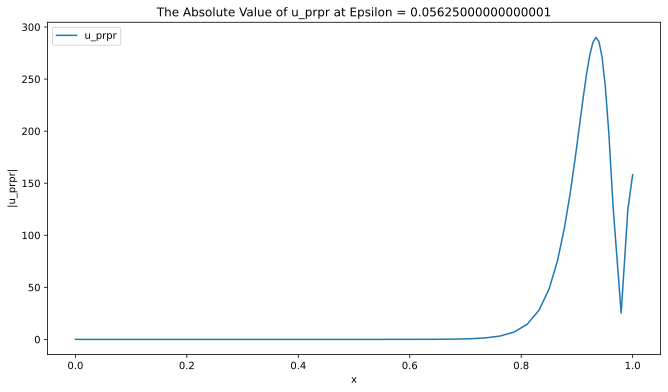



Epsilon continuation checks
norm(x) =  0.686616552306316
norm(u) =  1.9048232580986577



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.0421875
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.686616552306316
norm(u) =  1.9048232580986577



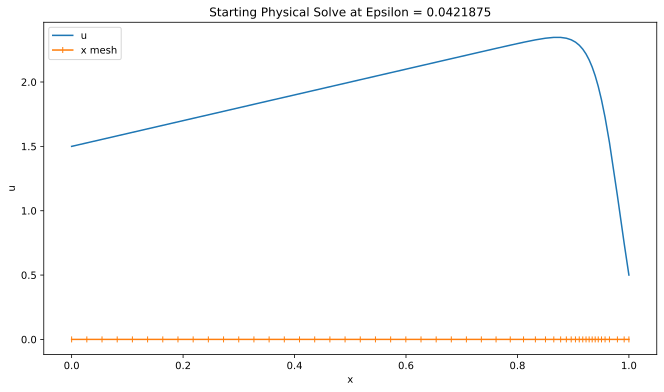




SINCE MESH TOLERANCE =  0.0035141964395344035 WE HAVE MESH CONVERGENCE IN 7 MP ITERATIONS


____________________________________________________________________________________________________
RESULTS
____________________________________________________________________________________________________

MESH RESIDUALS:
36.28134158445495, 28.203290623377175, 26.373110776892496, 25.869103651270176, 25.73949293566972, 25.751952609836035, 25.81571661984935, 

PLOT:


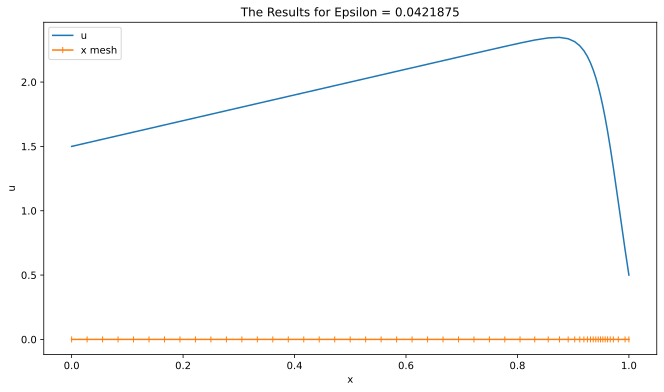

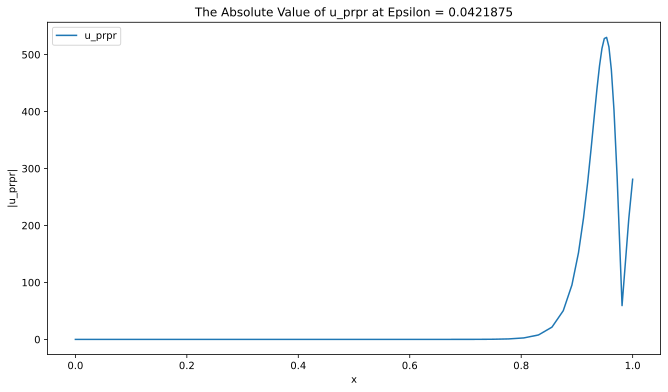



Epsilon continuation checks
norm(x) =  0.6988721654513745
norm(u) =  1.9324813975017843



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.031640625000000006
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.6988721654513745
norm(u) =  1.9324813975017843



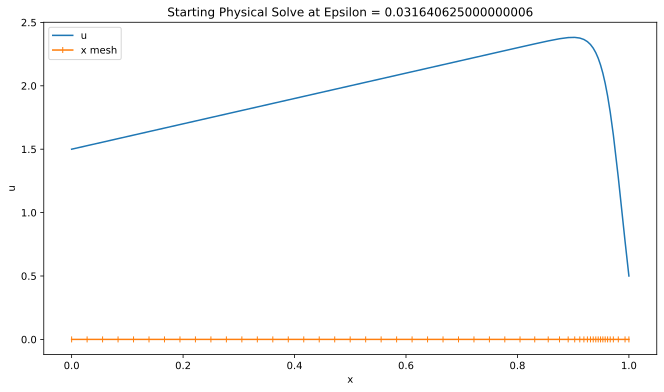




SINCE MESH TOLERANCE =  0.0030939947700488763 WE HAVE MESH CONVERGENCE IN 8 MP ITERATIONS


____________________________________________________________________________________________________
RESULTS
____________________________________________________________________________________________________

MESH RESIDUALS:
33.50384348387321, 28.3297201873911, 26.61912621423945, 26.08967708115381, 25.935861443130182, 25.93740685541531, 26.001822063842443, 26.08322894942516, 

PLOT:


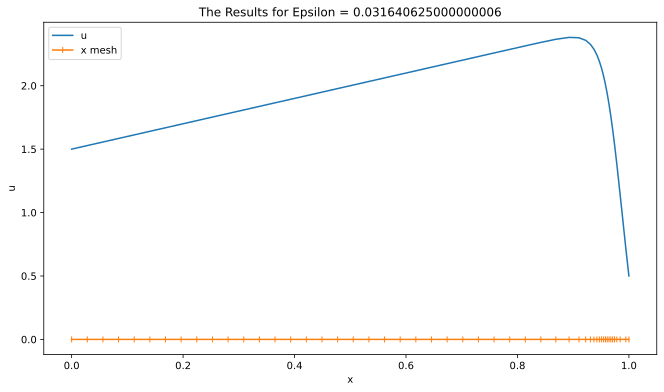

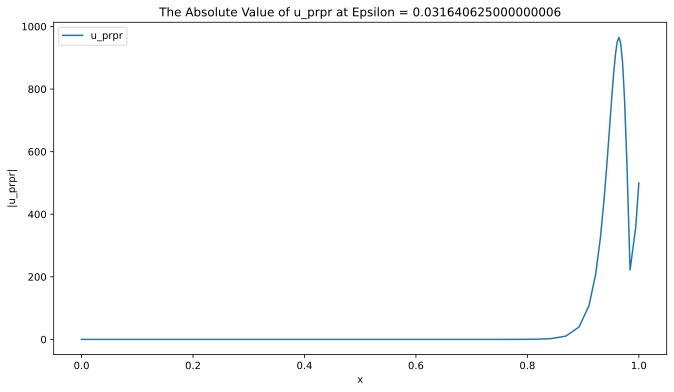



Epsilon continuation checks
norm(x) =  0.7076588444439527
norm(u) =  1.9512561918832179



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.023730468750000004
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7076588444439527
norm(u) =  1.9512561918832179



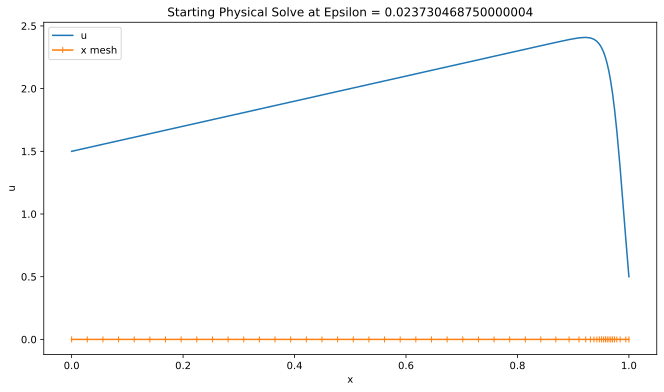




SINCE MESH TOLERANCE =  0.0019613092007279027 WE HAVE MESH CONVERGENCE IN 3 MP ITERATIONS


____________________________________________________________________________________________________
RESULTS
____________________________________________________________________________________________________

MESH RESIDUALS:
30.133819543646688, 29.453164837721353, 27.381429941196384, 

PLOT:


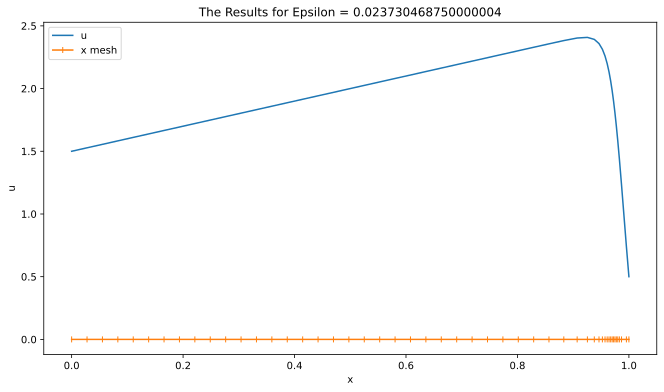

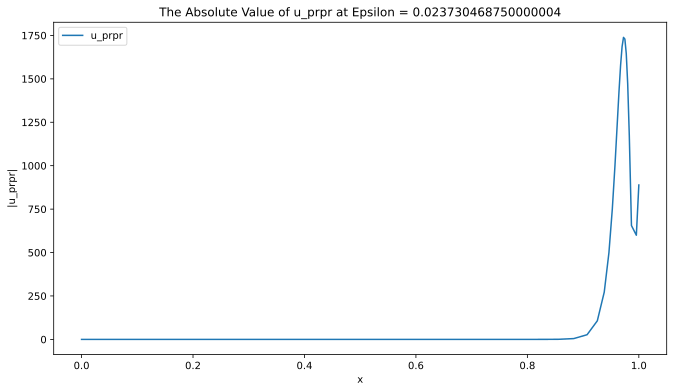



Epsilon continuation checks
norm(x) =  0.7068653451538702
norm(u) =  1.9649006087758623



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.0177978515625
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7068653451538702
norm(u) =  1.9649006087758623



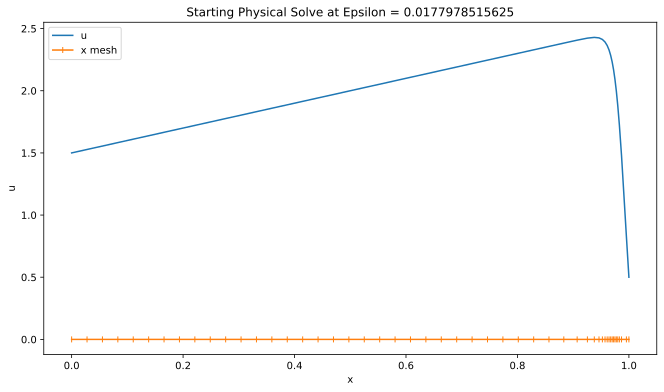




SINCE MESH TOLERANCE =  0.0016150474946939185 WE HAVE MESH CONVERGENCE IN 13 MP ITERATIONS


____________________________________________________________________________________________________
RESULTS
____________________________________________________________________________________________________

MESH RESIDUALS:
28.868962479146784, 28.784075674410772, 27.930956615951022, 26.831276228428248, 26.515166264241785, 26.360885953876398, 26.343605472012207, 26.34099813717505, 26.36871191977885, 26.41191237963037, 26.455647571481347, 26.494633769204285, 26.531502197227656, 

PLOT:


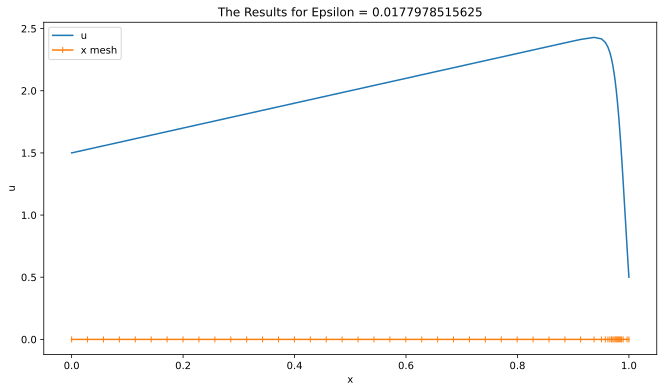

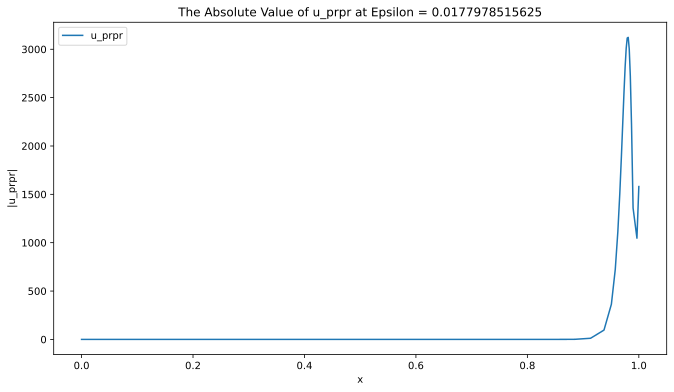



Epsilon continuation checks
norm(x) =  0.720008089603243
norm(u) =  1.9796587652639983



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.013348388671875001
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.720008089603243
norm(u) =  1.9796587652639983



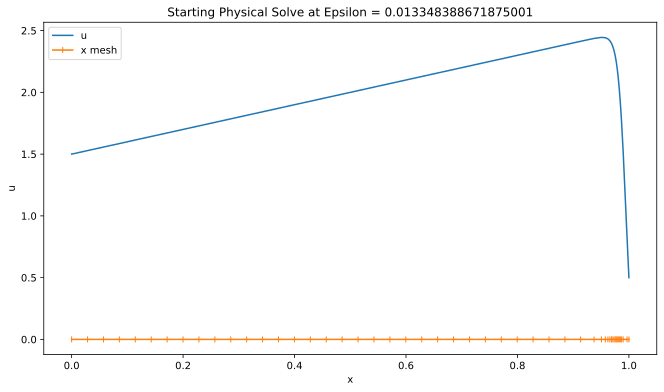




SINCE MESH TOLERANCE =  0.0011395619978129957 WE HAVE MESH CONVERGENCE IN 4 MP ITERATIONS


____________________________________________________________________________________________________
RESULTS
____________________________________________________________________________________________________

MESH RESIDUALS:
30.108788129086943, 28.81163918495544, 28.3591470003898, 27.252678334741578, 

PLOT:


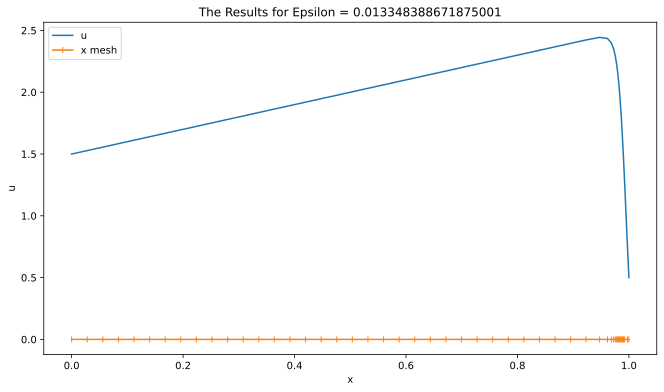

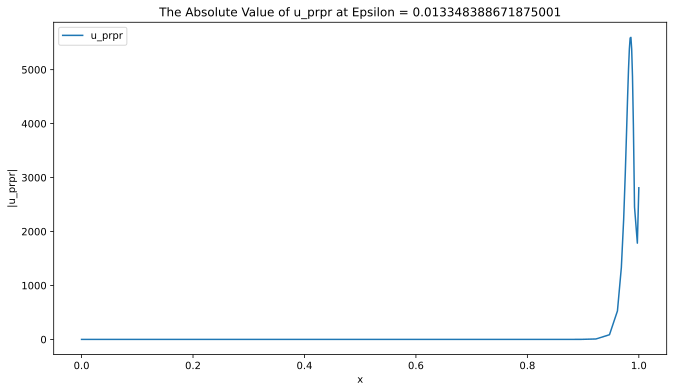



Epsilon continuation checks
norm(x) =  0.716427436875164
norm(u) =  1.9796288904384083



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.01001129150390625
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.716427436875164
norm(u) =  1.9796288904384083



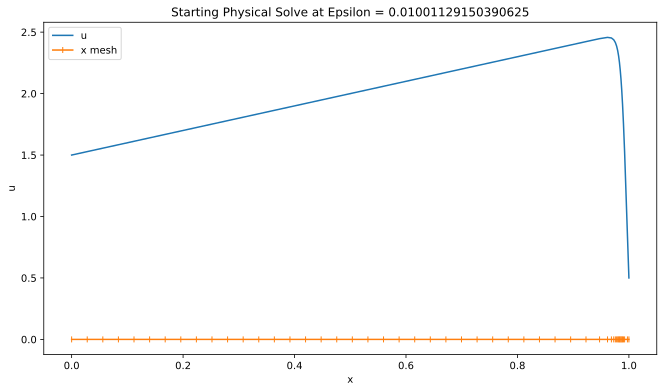




SINCE MESH TOLERANCE =  0.0007898154104006689 WE HAVE MESH CONVERGENCE IN 17 MP ITERATIONS


____________________________________________________________________________________________________
RESULTS
____________________________________________________________________________________________________

MESH RESIDUALS:
29.549692152302743, 28.860997946214013, 28.38985393616252, 27.363368683745094, 27.125345302269334, 26.984595165030225, 27.00823187375925, 27.213200867587265, 27.37975053883053, 27.306739235850067, 27.095978272439208, 26.931023064077916, 26.86930383142728, 26.869702899459515, 26.88639730147603, 26.900968839174688, 26.91197071928784, 

PLOT:


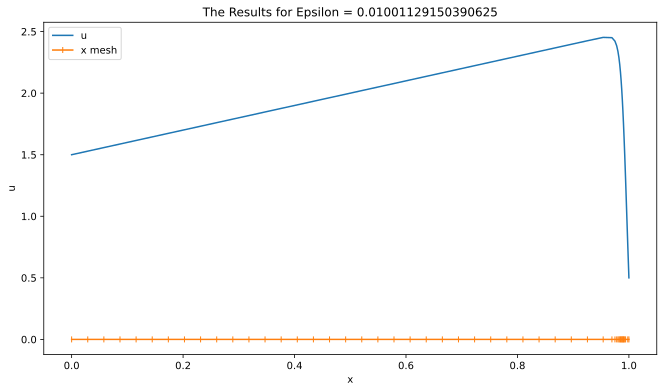

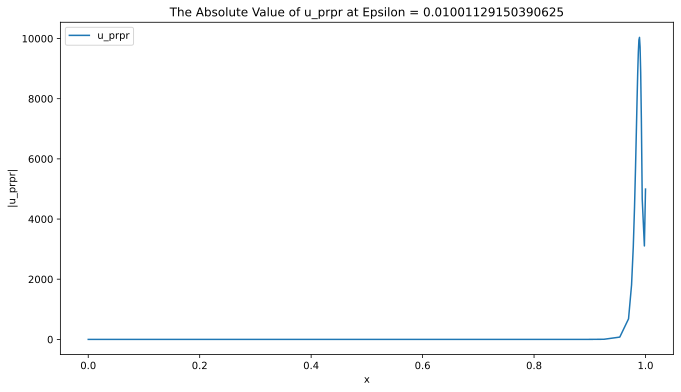



Epsilon continuation checks
norm(x) =  0.7282848212644659
norm(u) =  1.9932950102152096



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.007508468627929688
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7282848212644659
norm(u) =  1.9932950102152096



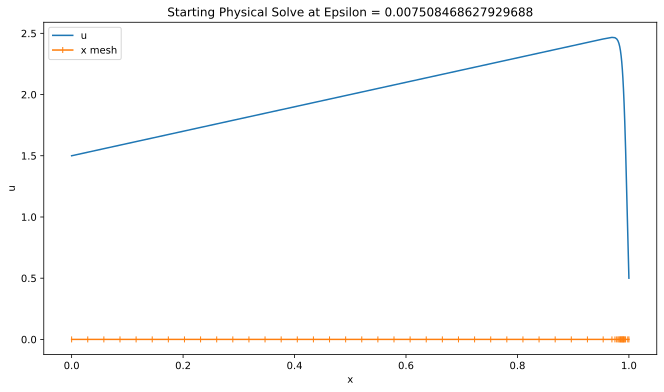




SINCE MESH TOLERANCE =  0.0006402882305164429 WE HAVE MESH CONVERGENCE IN 18 MP ITERATIONS


____________________________________________________________________________________________________
RESULTS
____________________________________________________________________________________________________

MESH RESIDUALS:
30.56036332503151, 29.390798242720894, 29.043320772537584, 27.885341772468244, 27.35385377522435, 27.04749159873134, 26.985261955833693, 27.15670532540082, 27.414525828423667, 27.52094556980523, 27.413619694264266, 27.21439996655383, 27.0578721863121, 26.98616957486383, 26.973975885568493, 26.98595751617441, 27.002057073884984, 27.015849421301144, 

PLOT:


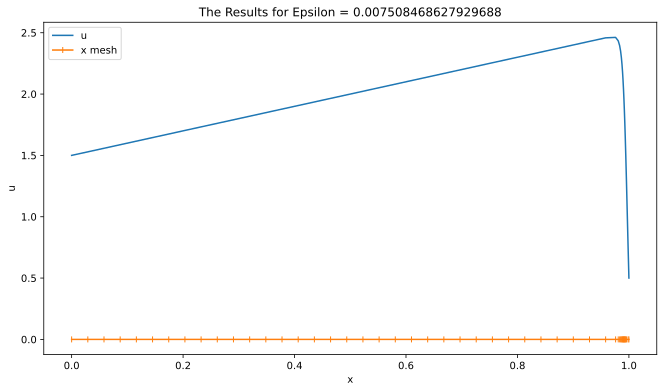

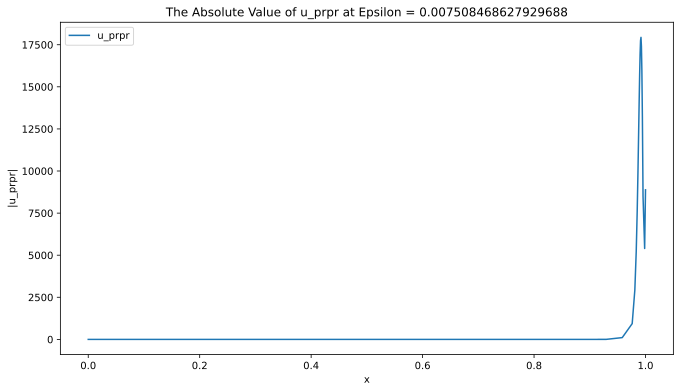



Epsilon continuation checks
norm(x) =  0.7309543660746387
norm(u) =  1.9975659491508104



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.005631351470947266
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7309543660746387
norm(u) =  1.9975659491508104



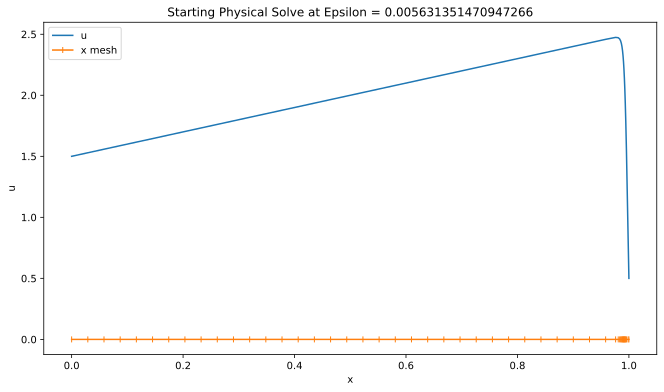




SINCE MESH TOLERANCE =  0.0004777220565715063 WE HAVE MESH CONVERGENCE IN 5 MP ITERATIONS


____________________________________________________________________________________________________
RESULTS
____________________________________________________________________________________________________

MESH RESIDUALS:
30.65701667581538, 29.64625561005651, 29.368829029904532, 28.178676177282767, 27.621869265254983, 

PLOT:


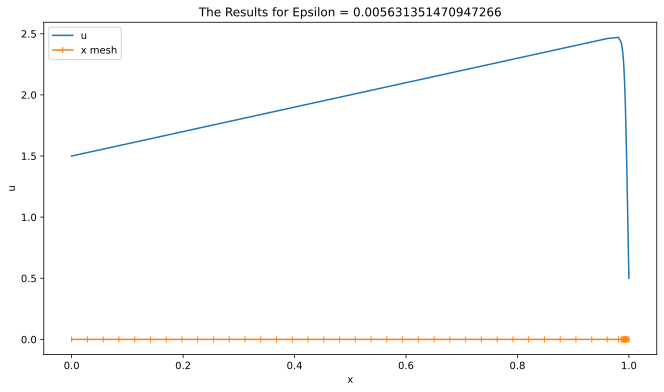

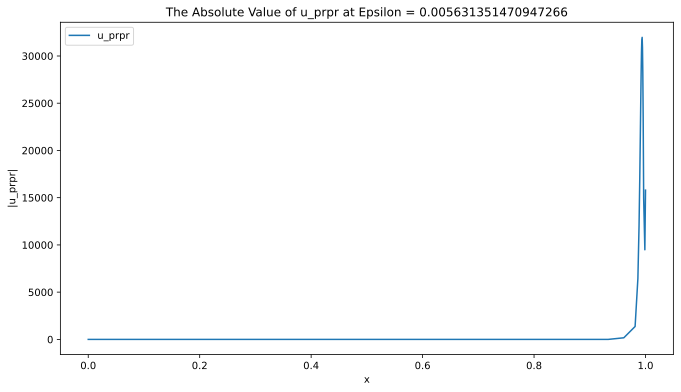



Epsilon continuation checks
norm(x) =  0.7239331432867113
norm(u) =  1.9903626336567757



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.004223513603210449
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7239331432867113
norm(u) =  1.9903626336567757



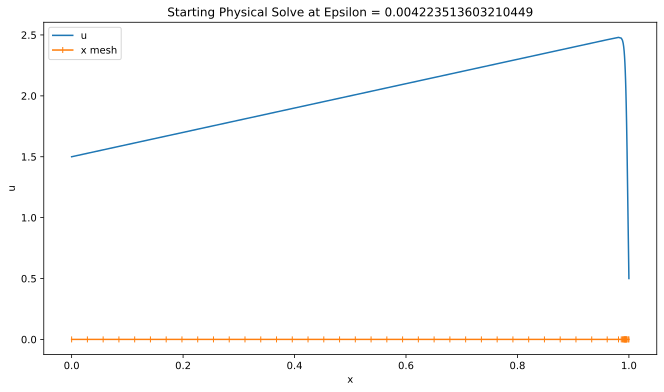




SINCE MESH TOLERANCE =  0.00033706159015182844 WE HAVE MESH CONVERGENCE IN 23 MP ITERATIONS


____________________________________________________________________________________________________
RESULTS
____________________________________________________________________________________________________

MESH RESIDUALS:
29.81855340767235, 29.18921508147433, 28.879539756248118, 27.793194237474587, 27.78976151071268, 28.58677560243502, 29.154177764257877, 28.746961129479452, 28.06566244134923, 27.73619478119373, 28.093886161864003, 28.609461359296713, 28.83636226947529, 28.68228260357826, 28.284502559864926, 27.839087113242705, 27.489985155816502, 27.281641591525204, 27.185811463160434, 27.15485693286319, 27.153145563840283, 27.161708860898454, 27.172277574732366, 

PLOT:


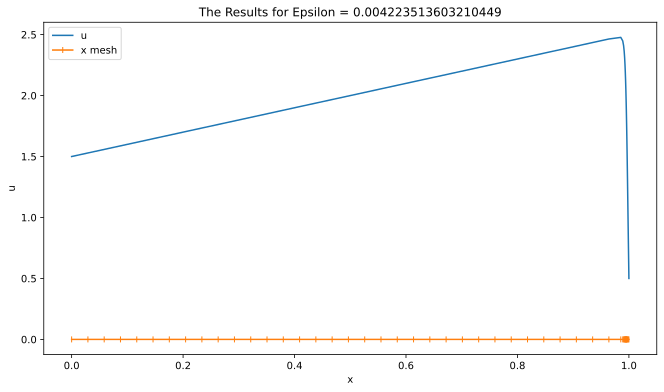

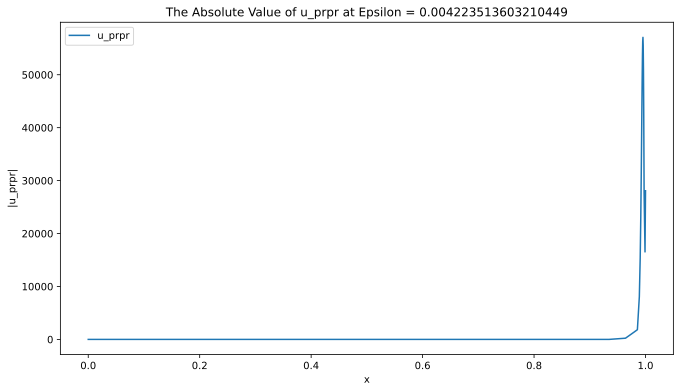



Epsilon continuation checks
norm(x) =  0.7347171461953673
norm(u) =  2.003447473458003



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.0031676352024078373
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7347171461953673
norm(u) =  2.003447473458003



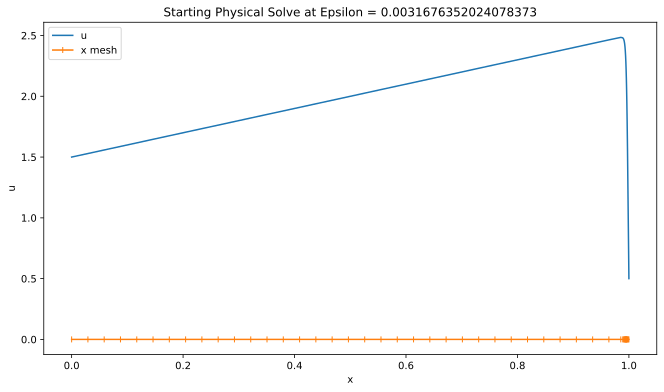




SINCE MESH TOLERANCE =  0.0002675923461046256 WE HAVE MESH CONVERGENCE IN 25 MP ITERATIONS


____________________________________________________________________________________________________
RESULTS
____________________________________________________________________________________________________

MESH RESIDUALS:
30.885207424147023, 30.251521356525377, 29.98628859076019, 28.60504942603837, 27.926185958509684, 27.809480957724894, 27.85675854740719, 27.679286788173222, 27.56947015377432, 27.734095489744135, 27.777550868638407, 28.21692489174763, 28.57436734400251, 28.645149471278994, 28.4651964250913, 28.147598093917388, 27.80868637925269, 27.531236752702316, 27.348043079424965, 27.250282590777275, 27.210660030075935, 27.20273394970706, 27.20867112327672, 27.218863096772633, 27.2289526882917, 

PLOT:


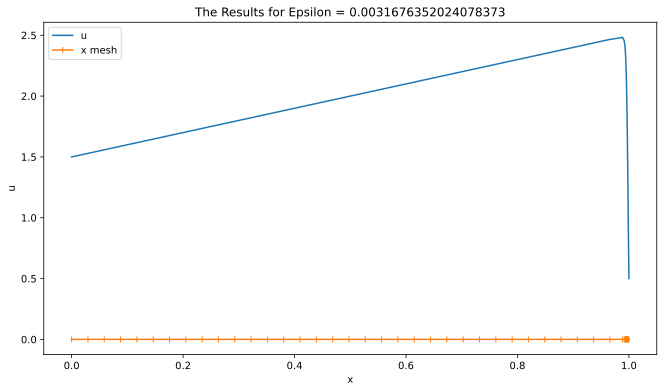

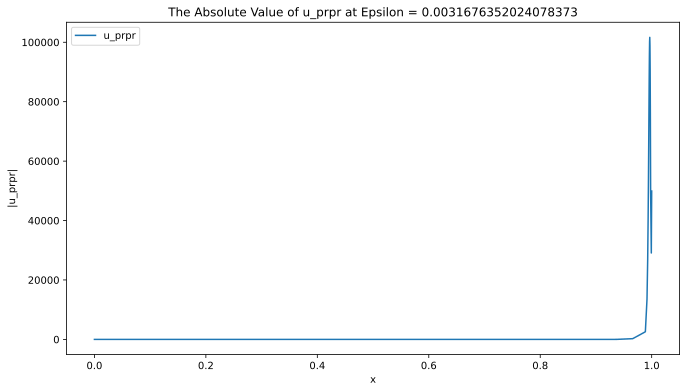



Epsilon continuation checks
norm(x) =  0.7359574411027748
norm(u) =  2.0053533706492415



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.002375726401805878
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7359574411027748
norm(u) =  2.0053533706492415



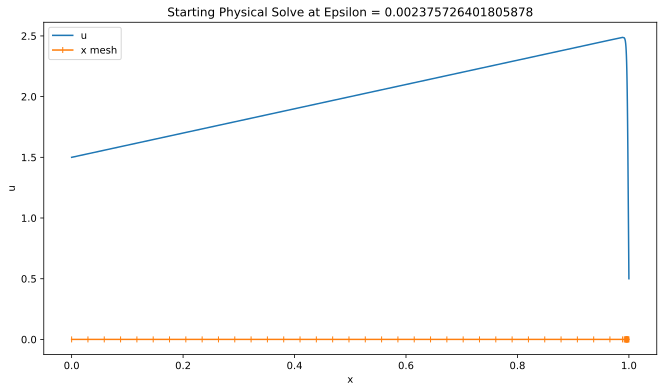




SINCE MESH TOLERANCE =  0.00017709937016685516 WE HAVE MESH CONVERGENCE IN 28 MP ITERATIONS


____________________________________________________________________________________________________
RESULTS
____________________________________________________________________________________________________

MESH RESIDUALS:
31.02082703250661, 30.569430074559143, 30.24614717554435, 28.792795650439963, 28.03914845103548, 27.983649118954403, 28.2893626353069, 28.206128274796505, 27.787577553847044, 27.7529403909702, 28.274555677614007, 28.66619068534901, 28.368723982080486, 28.462618069616614, 28.619434003165626, 28.549361434388665, 28.329945020990973, 28.048534122835864, 27.774263233514258, 27.550592718409657, 27.394298247382938, 27.300680293441495, 27.253889936089617, 27.23657344150608, 27.235088624295486, 27.24062432093295, 27.248258649526928, 27.255582428516874, 

PLOT:


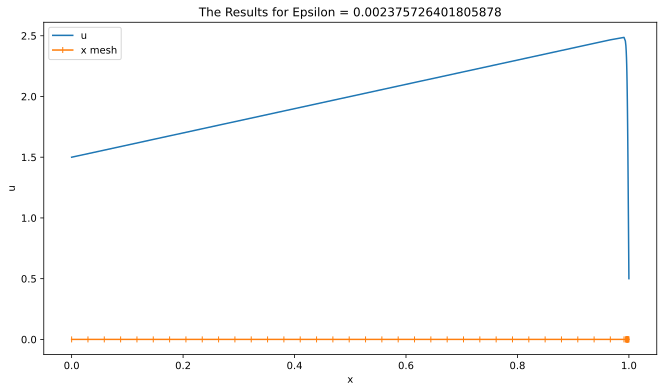

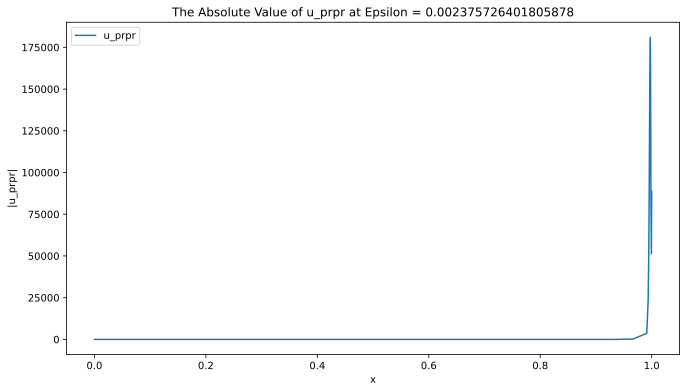



Epsilon continuation checks
norm(x) =  0.7367019933847153
norm(u) =  2.00643922108194



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.0017817948013544084
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7367019933847153
norm(u) =  2.00643922108194



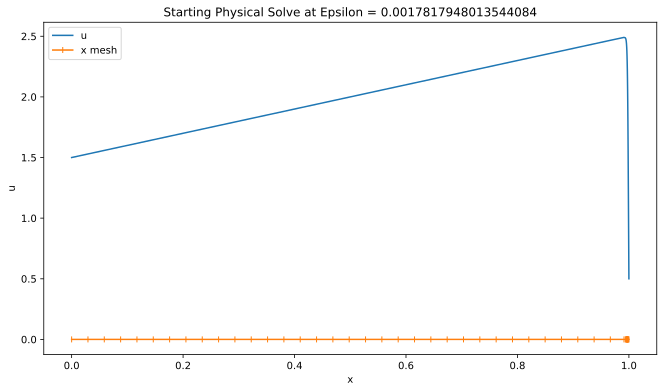




SINCE MESH TOLERANCE =  0.00016507047329085333 WE HAVE MESH CONVERGENCE IN 30 MP ITERATIONS


____________________________________________________________________________________________________
RESULTS
____________________________________________________________________________________________________

MESH RESIDUALS:
31.20543283190584, 30.91818635021727, 30.512574708301724, 28.987278518423995, 28.13190808643323, 28.064704679513593, 28.607707876074404, 28.812379828817985, 28.287841313216276, 27.686599851204967, 27.760429729761327, 28.53030417510377, 29.35416749613928, 29.50214778135825, 28.816218214124397, 28.403867335315915, 28.466459785764993, 28.3778471780465, 28.197842590192554, 27.98180515741638, 27.771025506386145, 27.59108865781321, 27.45393577589017, 27.360202115221217, 27.30306197876345, 27.27267647756978, 27.259616670201847, 27.256540635220478, 27.25847632114754, 27.262404342286285, 

PLOT:


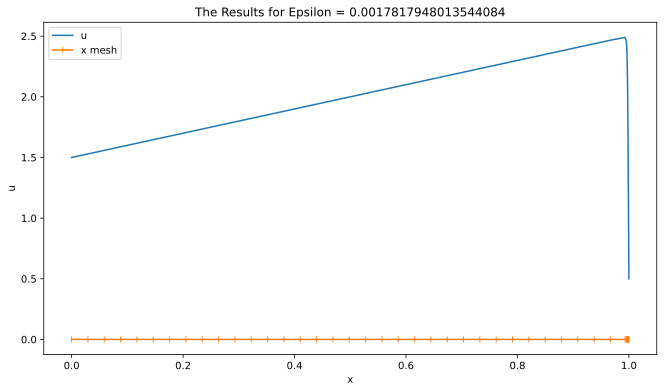

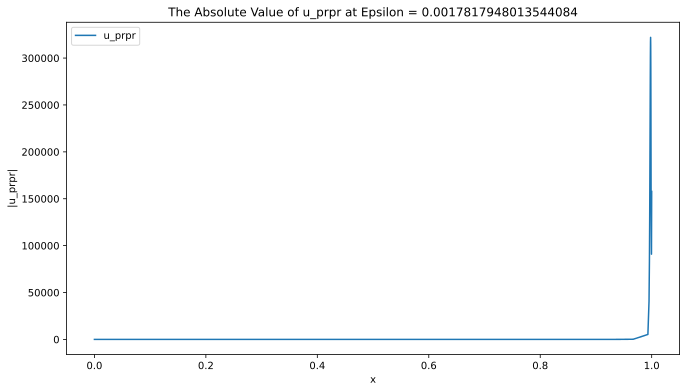



Epsilon continuation checks
norm(x) =  0.7371215228372859
norm(u) =  2.006996193041236



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.0013363461010158064
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7371215228372859
norm(u) =  2.006996193041236



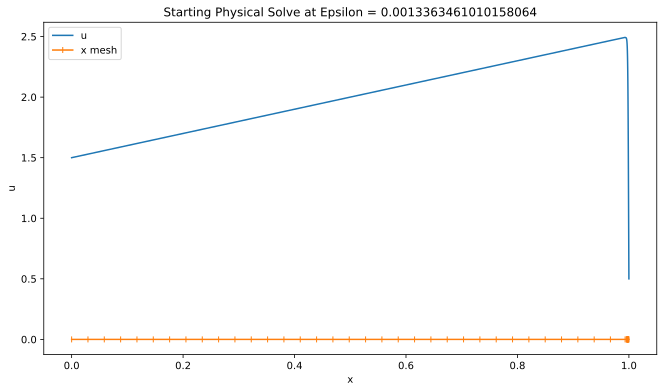




SINCE MESH TOLERANCE =  0.00011965365830592496 WE HAVE MESH CONVERGENCE IN 33 MP ITERATIONS


____________________________________________________________________________________________________
RESULTS
____________________________________________________________________________________________________

MESH RESIDUALS:
31.428865270954066, 31.26680567793949, 30.80249695858911, 29.16735359393286, 28.20956452568311, 28.08465955196814, 28.770883834099784, 29.279180529474516, 28.88805821220587, 27.99601899643191, 27.420112804308406, 27.520751035467658, 28.173004496464895, 29.061463484676857, 29.786431847626627, 29.92996783393337, 29.333242462606467, 28.347182145253875, 28.203187740781807, 28.192567163462584, 28.104038053858247, 27.970799097623974, 27.82195286172184, 27.67858457263557, 27.553937318380793, 27.454591727786525, 27.381677101142557, 27.33240990827315, 27.301934431425263, 27.284975062068163, 27.276903706082695, 27.274180257958175, 27.274358205562308, 

PLOT:


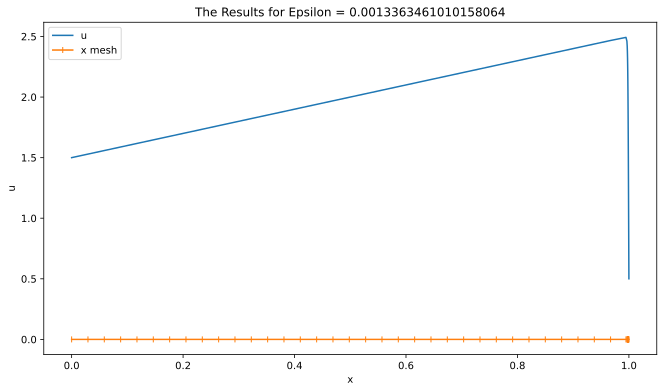

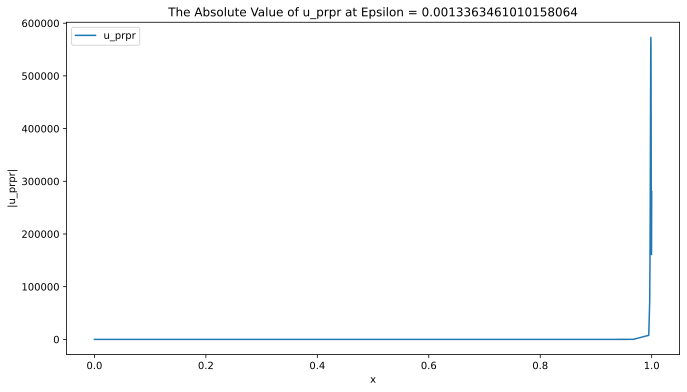



Epsilon continuation checks
norm(x) =  0.7374781288765211
norm(u) =  2.0074777476343786



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.0010022595757618548
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7374781288765211
norm(u) =  2.0074777476343786



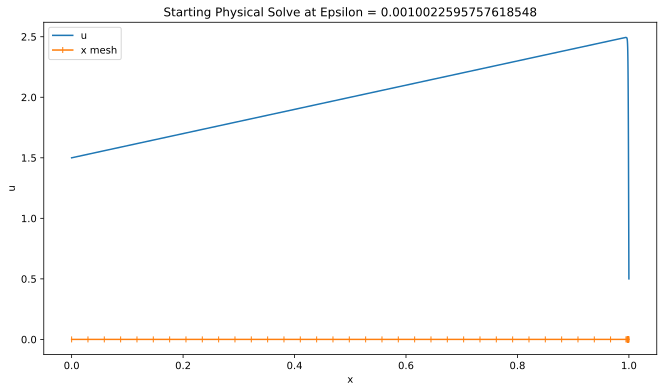




SINCE MESH TOLERANCE =  8.834694204435536e-05 WE HAVE MESH CONVERGENCE IN 37 MP ITERATIONS


____________________________________________________________________________________________________
RESULTS
____________________________________________________________________________________________________

MESH RESIDUALS:
31.624967317818122, 31.56946235507295, 31.08920367301884, 29.324050766387412, 28.27654942677323, 28.079352249065657, 28.84722703043146, 29.61972322801197, 29.442522037258172, 28.484011455533018, 27.55535260650728, 27.120843122370523, 27.139766482471355, 27.424785373936448, 27.853020697177175, 28.371772152884205, 28.933974621292574, 29.426419330592044, 29.642239564008193, 29.387986367325563, 28.709208331656512, 27.940606938191145, 27.91598314863412, 27.926990159342303, 27.88928400258641, 27.818220031287915, 27.72975161660656, 27.637143686123608, 27.550088077153756, 27.47471535603093, 27.413986790723165, 27.36825114515841, 27.336004724629966, 27.314746089264535, 27.30172

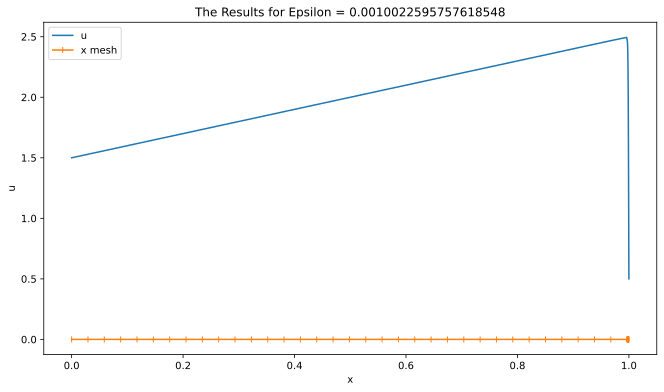

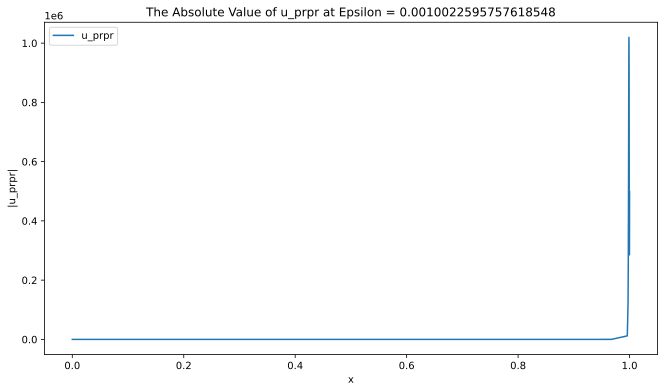



Epsilon continuation checks
norm(x) =  0.7377999706065579
norm(u) =  2.007927043735928



In [5]:
# SET EPSILONS
epsilon = 0.1
eps_final = 1e-3
eps_change = 3/4
results = []

# PICARD DAMPING
w = 1/2

# MP STOPPING CRITERIA
max_MP_iters = 100


# FUNCTIONS TO SAVE RESULTS
u_save = Function(V_phys)
x_save = Function(V_mesh)


# M PARAMETERS (m=0 IS L2)
p = 2
q = 2
m = 0
exp_M = Constant( (2*q) / (1 + q*(2-m)) )
alpha_power = -3/4
alpha_scale = 5


# INITIAL GUESSES
x = Function(V_mesh).interpolate(SpatialCoordinate(xi_mesh)[0])
u = Function(V_phys).interpolate(x+1/2)


# EPSILON CONTINUATION
##########################################################


while epsilon >= eps_final:


    print()
    print()
    print('-_'*100)
    print('EPSILON = ', epsilon)
    print('-_'*100)
    print()
    print()


    mesh_convergence = False
    mesh_norms = []
    mesh_residuals = []
    mesh_tol = (1/10) * epsilon
    MP_Iter = 0

    # continuation checks
    print('Epsilon continuation checks')
    print("norm(x) = ", norm(x))
    print("norm(u) = ", norm(u))
    print()


    # STARTING NONLINEAR PHYSICAL SOLVE AT NEW EPSILON ON OLD MESH



    # Test and Solution Functions
    u_new = Function(V_phys)
    v = TestFunction(V_phys)

    # Jacobian of x
    Jx = x.dx(0) #dx/dxi

    # Derivatives
    u_deriv = (1/Jx) * u_new.dx(0)
    v_deriv = (1/Jx) * v.dx(0)

    # The residual
    F1 = ( (epsilon**2) * u_deriv * v_deriv) * Jx * dx
    F2 = (u_new * (u_new-1) * (u_new - x - 3/2) * v) * Jx * dx
    F = F1 + F2

    # BC's
    bcs = [DirichletBC(V_phys, 3/2, 1), DirichletBC(V_phys, 1/2, 2)]


    # Solve
    try:
      u_new.interpolate(u) # initial guess
      solve( F==0 , u_new, bcs = bcs, solver_parameters = newton_params)
    except Exception as e:
      print('The physical solve failed due to the following message:')
      print(e)
      print()

    # Update u
    u.dat.data[:] = u_new.dat.data[:]


    # plot
    plt.plot(x.dat.data[perm_x], Function(V_mesh).interpolate(u).dat.data[perm_x], label = 'u')
    plt.plot(x.dat.data[perm_x], [0 for i in range(len(x.dat.data[perm_x]))], marker = '|', label = 'x mesh')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.title('Starting Physical Solve at Epsilon = ' + str(epsilon))
    plt.legend()
    plt.show()
    print()
    print()



    # MP ITERATION
    ##############################################################



    while not(mesh_convergence):

        MP_Iter += 1



        # Check Max iterations
        if MP_Iter > max_MP_iters:
          print()
          print('MAX MP ITERATIONS REACHED SO WE BREAK!')
          print('THE LAST 5 MESH NORMS ARE:', end = "  ")
          print(mesh_norms[-5:])
          print()
          break




        # MESH DENSITY FUNCTION



        # Compute u'
        Jx = x.dx(0)
        upr_f = (1/Jx) * u.dx(0)
        # Compute u''
        u_pr_xi = u.dx(0)
        u_prpr_xi = u_pr_xi.dx(0)
        x_prpr_xi = Jx.dx(0)
        u_prpr = ( u_prpr_xi -  upr_f * x_prpr_xi) * (( 1/Jx )**2)

        # Compute M
        alpha_hat = alpha_scale * epsilon ** (alpha_power)
        # alpha_term1 = float(alpha_hat * sqrt(assemble(u_e*u_e* Jm * dx)))
        M = ( 1 + (1/alpha_hat) * abs(u_prpr) )**exp_M



        # MESH RESIDUAL
        vr = TestFunction(V_mesh)
        residual = Cofunction(V_mesh.dual())
        assemble(inner(M * x.dx(0), vr.dx(0))*dx, tensor=residual)
        mesh_residuals.append(norm(residual.riesz_representation()))





        # LINEAR MESH SOLVE




        # set solution and test function
        new_x = Function(V_mesh)
        vm = TestFunction(V_mesh)


        # jacobian
        Jm = new_x.dx(0) #dx/dxi

        # v'
        v_pr_term = (vm).dx(0)

        # the lhs of the eqn
        F = (M * Jm * v_pr_term) * dx




        # bc's
        bc0 = DirichletBC(V_mesh, Constant(0), 1)
        bc1 = DirichletBC(V_mesh, Constant(1), 2)
        bcs = [bc0, bc1]

        # initial guess
        new_x.dat.data[:] = x.dat.data[:]

        # The actual solve
        try:
          solve( F == 0, new_x, bcs = bcs, solver_parameters=newton_params)
        except Exception as e:
          print('MESH SOLVE FAILED BECAUSE ', e)
          print()
          print()
          break


        # check mesh convergence
        mesh_norm = errornorm(new_x, x)
        mesh_norms.append(mesh_norm)

        if mesh_norm <= mesh_tol: # then the meshes have converged
          print()
          print('SINCE MESH TOLERANCE = ', mesh_norm, "WE HAVE MESH CONVERGENCE IN", MP_Iter, "MP ITERATIONS")
          print()
          mesh_convergence = True



        # update our x
        x.interpolate( (1-w) * x + w * new_x)




        # NONLINEAR PHYSICAL SOLVE




        # Test and Solution Functions
        u_new = Function(V_phys)
        v = TestFunction(V_phys)

        # Jacobian of x
        Jx = x.dx(0) #dx/dxi

        # Derivatives
        u_deriv = (1/Jx) * u_new.dx(0)
        v_deriv = (1/Jx) * v.dx(0)

        # The residual
        F1 = ( (epsilon**2) * u_deriv * v_deriv) * Jx * dx
        F2 = (u_new * (u_new-1) * (u_new - x - 3/2) * v) * Jx * dx
        F = F1 + F2

        # BC's
        bcs = [DirichletBC(V_phys, 3/2, 1), DirichletBC(V_phys, 1/2, 2)]


        # Solve
        try:
          u_new.interpolate(u)
          solve( F==0, u_new, bcs = bcs, solver_parameters = newton_params)
        except Exception as e:
          print('The physical solve failed due to the following message:')
          print(e)
          print()
          break

        # Update u
        u.dat.data[:] = u_new.dat.data[:]




    # L2 AND ENERGY NORM FOR RESULT OF CURRENT EPSILON



    print()
    print('_'*100)
    print('RESULTS')
    print('_'*100)
    print()


    print("MESH RESIDUALS:")
    for r in mesh_residuals:
      print(r, end = ", ")
    print()
    print()


    # SAVE AND PLOT THE RESULTS FOR THE CURRENT EPSILON

    # save
    u_save.dat.data[:] = u.dat.data[:]
    x_save.dat.data[:] = x.dat.data[:]
    results.append([epsilon, u_save, x_save])

    # plot
    print("PLOT:")
    plt.plot(x.dat.data[perm_x], Function(V_mesh).interpolate(u).dat.data[perm_x], label = 'u')
    plt.plot(x.dat.data[perm_x], [0 for i in range(len(x.dat.data[perm_x]))], marker = '|', label = 'x mesh')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.title('The Results for Epsilon = ' + str(epsilon))
    plt.legend()
    plt.show()
    print()
    print()

    # Let's take a look at abs(u_prpr)
    plt.plot(x.dat.data[perm_x], Function(V_mesh).interpolate(abs(u_prpr)).dat.data[perm_x], label = 'u_prpr')
    plt.xlabel('x')
    plt.ylabel('|u_prpr|')
    plt.title('The Absolute Value of u_prpr at Epsilon = ' + str(epsilon))
    plt.legend()
    plt.show()
    print()
    print()


    # UPDATE EPSILON
    epsilon = epsilon * eps_change


    # continuation checks
    print('Epsilon continuation checks')
    print("norm(x) = ", norm(x))
    print("norm(u) = ", norm(u))
    print()


